<a href="https://colab.research.google.com/github/GunKK/capstone-project-brain-tumor-segmentation/blob/master/yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from glob import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import cv2
IMG_HEIGHT=256
IMG_WIDTH=256

In [3]:
def load_image(path):
    image=cv2.imread(path)
    image=cv2.resize(image,(IMG_WIDTH,IMG_HEIGHT))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)
    return image/255.0

def load_label(path):
    image=cv2.imread(path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float32)
    return np.expand_dims(image/255.0,axis=-1)

In [37]:
# load dataset yolo
data_path = '/content/drive/MyDrive/DATN/dataset_yolo'
images=[]
masks=[]

# load images
for i in sorted(os.listdir(data_path + "/images")):
  images.append(data_path + "/images/" + i)

for i in sorted(os.listdir(data_path + "/masks")):
  masks.append(data_path + "/masks/" + i)

for i in range(0,5):
  print(images[i])
  print(masks[i])

/content/drive/MyDrive/DATN/dataset_yolo/images/1.png
/content/drive/MyDrive/DATN/dataset_yolo/masks/1.png
/content/drive/MyDrive/DATN/dataset_yolo/images/10.png
/content/drive/MyDrive/DATN/dataset_yolo/masks/10.png
/content/drive/MyDrive/DATN/dataset_yolo/images/100.png
/content/drive/MyDrive/DATN/dataset_yolo/masks/100.png
/content/drive/MyDrive/DATN/dataset_yolo/images/1000.png
/content/drive/MyDrive/DATN/dataset_yolo/masks/1000.png
/content/drive/MyDrive/DATN/dataset_yolo/images/1001.png
/content/drive/MyDrive/DATN/dataset_yolo/masks/1001.png


In [5]:
def xyxy(masks):
    x_min=[]
    y_min=[]
    x_max=[]
    y_max=[]
    zoom=5
    for path in masks:
        mask=load_label(path)
        occurrence = np.where(mask == 1)
        ymin=np.sort(occurrence[0])[0]
        ymax=np.sort(occurrence[0])[-1]
        xmin=np.sort(occurrence[1])[0]
        xmax=np.sort(occurrence[1])[-1]
        x_min.append(xmin-zoom)
        y_min.append(ymin-zoom)
        x_max.append(xmax+zoom)
        y_max.append(ymax+zoom)
    return (x_min,y_min,x_max,y_max)

In [38]:
xy_xy=xyxy(masks)

In [39]:
def show_sample(cnt):

    pic1=load_image(images[cnt])[0]
    pic2=load_label(masks[cnt])
    mask=load_image(images[cnt])[0]
    cv2.rectangle(mask, (xy_xy[0][cnt],xy_xy[1][cnt]),(xy_xy[2][cnt],xy_xy[3][cnt]), (0, 1, 0), 0)

    fig = plt.figure(figsize=(7, 6))

    ax = fig.add_subplot(1, 3, 1)
    ax.set_title("Brain Image")
    plt.imshow(pic1)

    ax = fig.add_subplot(1, 3, 2)
    ax.set_title("The Mask")
    plt.imshow(pic2)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(mask)

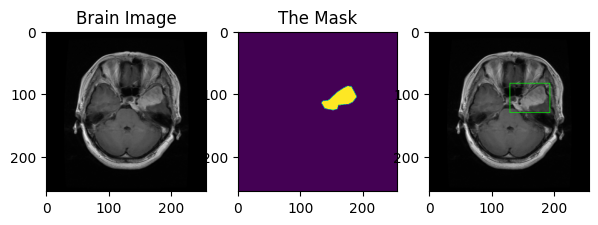

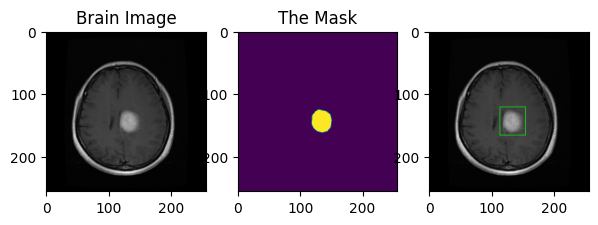

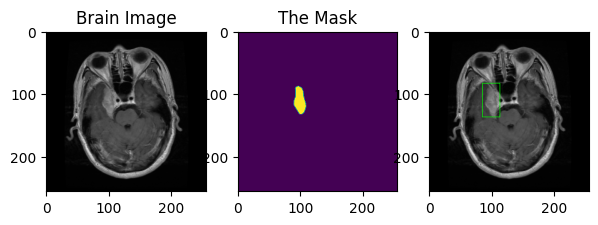

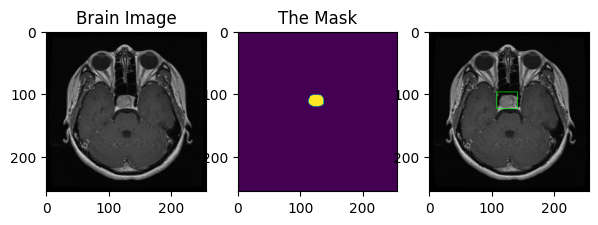

In [40]:
for i in range(0,4):
    show_sample(i)

In [41]:
load_label(masks[0]).shape

(256, 256, 1)

In [42]:
binary_mask = load_label(masks[0])
binarya_mask = binary_mask.reshape(IMG_WIDTH, IMG_WIDTH)
binary_mask = binary_mask.astype(np.uint8)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [43]:
def mask_to_yolo_contours(mask, annotation_file):
    open(annotation_file, "w").close()
    binary_mask = load_label(mask)

    binarya_mask = binary_mask.reshape(IMG_WIDTH, IMG_WIDTH)
    binary_mask = binary_mask.astype(np.uint8)

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        st = '0 '
        for i in cnt:
            st += str(i[0][0]/256) + ' ' + str(i[0][1]/256) + ' '
        with open(annotation_file, 'a') as ann_file:
            ann_file.write(st + '\n')

In [12]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-a3m3xsjl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-a3m3xsjl
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-05-26 08:13:15--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 54.192.18.51, 54.192.18.81, 54.192.18.54, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|54.192.18.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  50.2MB/s    in 31s     

2024-05-26 08:13:46 (78.3 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



In [13]:
!pip install -U ultralytics

In [14]:
!pip install -U ipywidgets

In [15]:
# import yolo
import ultralytics
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
ultralytics.checks()

# yolo_model = YOLO('yolov8n-seg')
yolo_model = YOLO("yolov8n.pt")

Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 35.8/107.7 GB disk)


In [16]:
print(yolo_model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [17]:
# input_shape = (None, IMG_HEIGHT, IMG_WIDTH, 3)
print(yolo_model.info())

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs
(225, 3157200, 0, 8.8575488)


In [44]:
df = pd.DataFrame(images,columns=['images_path'])
df['mask_path'] = masks
df.head()

,images_path,mask_path
0,/content/drive/MyDrive/DATN/dataset_yolo/image...,/content/drive/MyDrive/DATN/dataset_yolo/masks...
1,/content/drive/MyDrive/DATN/dataset_yolo/image...,/content/drive/MyDrive/DATN/dataset_yolo/masks...
2,/content/drive/MyDrive/DATN/dataset_yolo/image...,/content/drive/MyDrive/DATN/dataset_yolo/masks...
3,/content/drive/MyDrive/DATN/dataset_yolo/image...,/content/drive/MyDrive/DATN/dataset_yolo/masks...
4,/content/drive/MyDrive/DATN/dataset_yolo/image...,/content/drive/MyDrive/DATN/dataset_yolo/masks...


In [45]:
# split data train and test
from sklearn.model_selection import train_test_split

files = list(df.images_path.unique())
files_train,files_valid = train_test_split(files,test_size=0.2,random_state=42)
len(files_train),len(files_valid)

(2451, 613)

In [46]:
IMAGES = "/content/drive/MyDrive/DATN/yolo_v1/images/"
LABELS = "/content/drive/MyDrive/DATN/yolo_v1/labels/"
os.makedirs(IMAGES+"train", exist_ok=True)
os.makedirs(LABELS+"train", exist_ok=True)
os.makedirs(IMAGES+"valid", exist_ok=True)
os.makedirs(LABELS+"valid", exist_ok=True)

In [48]:
import shutil

train_filename = set(files_train)
valid_filename = set(files_valid)
# file ~ image_file
#
for i,file in enumerate(files):
    if file in train_filename:
        shutil.copy(file, IMAGES+"train")
        name = file.split("/")[7]
        anno_file = os.path.join(LABELS) + "train/"+name.replace('.png', '.txt')
        mask = os.path.join(data_path) + "/masks/" + name
        # params mask.png and ano_file.txt
        mask_to_yolo_contours(mask, anno_file)

    elif file in valid_filename:
        shutil.copy(file, IMAGES+"valid")
        name = file.split("/")[7]
        anno_file = os.path.join(LABELS) + "valid/"+name.replace('.png', '.txt')
        mask = os.path.join(data_path) + "/masks/" + name
        mask_to_yolo_contours(mask, anno_file)

In [49]:
%%writefile  /content/drive/MyDrive/DATN/yolo_v1/dataset.yaml
# Path
train: /content/drive/MyDrive/DATN/yolo_v1/images/train
val: /content/drive/MyDrive/DATN/yolo_v1/images/valid

# Classes
nc: 1
names: ['Tumor']

Writing /content/drive/MyDrive/DATN/yolo_v1/dataset.yaml


In [50]:
# train model
yolo_model.train(data="/content/drive/MyDrive/DATN/yolo_v1/dataset.yaml", epochs=1, batch=2,lr0=0.00001)

Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/DATN/yolo_v1/dataset.yaml, epochs=1, time=None, patience=100, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning /content/drive/MyDrive/DATN/yolo_v1/labels/train... 2451 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2451/2451 [01:18<00:00, 31.19it/s] 


train: New cache created: /content/drive/MyDrive/DATN/yolo_v1/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/DATN/yolo_v1/labels/valid... 613 images, 0 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:09<00:00, 65.25it/s] 


val: New cache created: /content/drive/MyDrive/DATN/yolo_v1/labels/valid.cache
Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train9
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.681      3.415      1.546          1        640: 100%|██████████| 1226/1226 [34:51<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [03:17<00:00,  1.28s/it]


                   all        613        613       0.67      0.506      0.561      0.321

1 epochs completed in 0.640 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 6.2MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [02:55<00:00,  1.14s/it]


                   all        613        613      0.665      0.503      0.561      0.319
Speed: 2.4ms preprocess, 257.9ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/detect/train9


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f01042c7880>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 